# Obtaining development constants using EM algorithm

#### Importing modules

In [22]:
import sys
print(sys. version)

3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from scipy.stats import weibull_min, beta, norm, kruskal, ttest_ind, mannwhitneyu
from scipy.optimize import root, root_scalar
from scipy.spatial.distance import pdist
from tqdm.notebook import tqdm
from lifelines import WeibullFitter
import scipy.stats as stats
import random
from scipy.stats import levene
import pickle

#### Data exploration

In [24]:
creophilus_maxillosus = pd.read_excel("datasets/Creophilus_maxillosus.xlsx").iloc[:,[0,4]]
creophilus_maxillosus.rename(columns={"Total immature development":"D", "T":"T"}, inplace = True)
necrodes_littoralis = pd.read_excel("datasets/Necrodes_littoralis.xlsx").iloc[:,[9,4]]
necrodes_littoralis.rename(columns={"TIME (D)":"D", "TEMP.":"T"}, inplace = True)

In [25]:
def plot_scatter(x, xtitle, y, ytitle):
    fig, ax = plt.subplots(1, 2, sharey=False, sharex = True)
    ax[0].scatter(x['T'], x['D'])
    ax[0].set_title(xtitle)
    ax[1].scatter(y['T'], y['D'])
    ax[1].set_title(ytitle)
    fig.supxlabel('temperature')
    fig.supylabel('time of development')
    plt.savefig('Necrodes_Creophilus_comparison.png')
    plt.show()

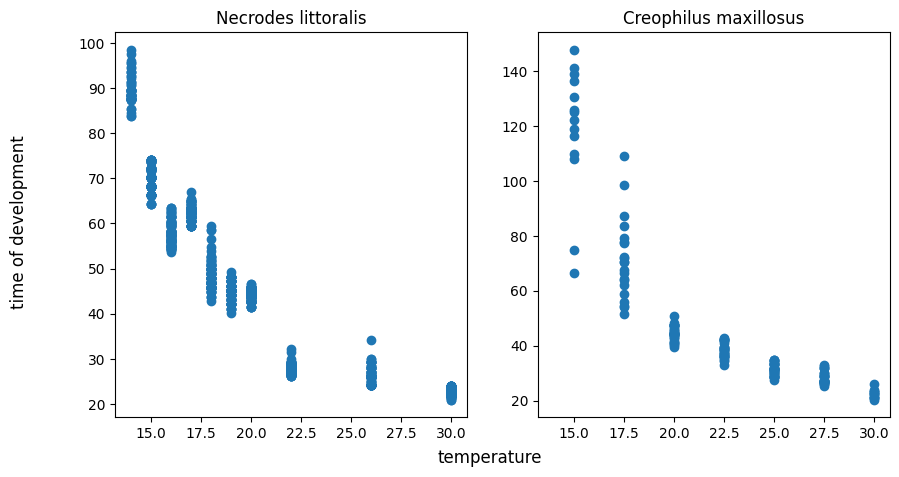

In [26]:
plt.rcParams['figure.figsize'] = [10, 5]
plot_scatter(necrodes_littoralis, "Necrodes littoralis", creophilus_maxillosus, "Creophilus maxillosus")


| | Necrodes littoralis | Creophilus maxillosus |
| --- | ----------- | ----------- |
| $k$ | 468.89 | 417.33 |
| $se$ | 24.59 | 19.52 |
| $t_0$ | 8.49 | 11.58 |


In [27]:
DT_nl = necrodes_littoralis['D'] * necrodes_littoralis['T']
reg_nl = necrodes_littoralis['D'] * 8.49 + 468.89
nl = DT_nl - reg_nl
stats.shapiro(nl)

ShapiroResult(statistic=0.977317570806209, pvalue=4.893988391625715e-11)

In [28]:
necrodes_littoralis2 = necrodes_littoralis.groupby('T').agg(D = ('D', 'median'), T = ('T', 'mean'))

In [29]:
DT_nl = necrodes_littoralis2['D'] * necrodes_littoralis2['T']
reg_nl = necrodes_littoralis2['D'] * 8.49 + 468.89
nl = DT_nl - reg_nl
stats.shapiro(nl)

ShapiroResult(statistic=0.9499226116960992, pvalue=0.6675850206931873)

In [30]:
DT_cm = creophilus_maxillosus['D'] * creophilus_maxillosus['T']
reg_cm = creophilus_maxillosus['D'] * 11.58 + 417.33
cm = DT_cm - reg_cm
stats.shapiro(cm)

ShapiroResult(statistic=0.9552899032426102, pvalue=2.5969433787620294e-05)

In [31]:
creophilus_maxillosus2 = creophilus_maxillosus.groupby('T').agg(D = ('D', 'median'), T = ('T', 'mean'))

In [32]:
DT_cm = creophilus_maxillosus2['D'] * creophilus_maxillosus2['T']
reg_cm = creophilus_maxillosus2['D'] * 11.58 + 417.33
cm = DT_cm - reg_cm
stats.shapiro(cm)

ShapiroResult(statistic=0.8052358241857724, pvalue=0.04613472970473144)

In [33]:
up = (creophilus_maxillosus['D'] * (creophilus_maxillosus['T'] - 11.58) <= 417.33 + 19.52)
lo = (creophilus_maxillosus['D'] * (creophilus_maxillosus['T'] - 11.58) >= 417.33 - 19.52)
cp_necrodes = np.round(np.mean(up & lo), decimals = 2)

up = (necrodes_littoralis['D'] * (necrodes_littoralis['T'] - 8.49) <= 468.89 + 24.59)
lo = (necrodes_littoralis['D'] * (necrodes_littoralis['T'] - 8.49) >= 468.89 - 24.59)
cp_creophilus = np.round(np.mean(up & lo), decimals = 2)

print("Necrodes littoralis:", cp_necrodes)
print("Creophilus maxillosus:", cp_creophilus)

Necrodes littoralis: 0.38
Creophilus maxillosus: 0.4


In [34]:
up = (creophilus_maxillosus['D'] * (creophilus_maxillosus['T'] - 11.58) <= 417.33 + 2*19.52)
lo = (creophilus_maxillosus['D'] * (creophilus_maxillosus['T'] - 11.58) >= 417.33 - 2*19.52)
cp_necrodes = np.round(np.mean(up & lo), decimals = 2)

up = (necrodes_littoralis['D'] * (necrodes_littoralis['T'] - 8.49) <= 468.89 + 2*24.59)
lo = (necrodes_littoralis['D'] * (necrodes_littoralis['T'] - 8.49) >= 468.89 - 2*24.59)
cp_creophilus = np.round(np.mean(up & lo), decimals = 2)

print("Necrodes littoralis:", cp_necrodes)
print("Creophilus maxillosus:", cp_creophilus)

Necrodes littoralis: 0.59
Creophilus maxillosus: 0.75


a dla $[k - 3se, k + 3se]$:

In [35]:
up = (creophilus_maxillosus['D'] * (creophilus_maxillosus['T'] - 11.58) <= 417.33 + 3*19.52)
lo = (creophilus_maxillosus['D'] * (creophilus_maxillosus['T'] - 11.58) >= 417.33 - 3*19.52)
cp_necrodes = np.round(np.mean(up & lo), decimals = 2)

up = (necrodes_littoralis['D'] * (necrodes_littoralis['T'] - 8.49) <= 468.89 + 3*24.59)
lo = (necrodes_littoralis['D'] * (necrodes_littoralis['T'] - 8.49) >= 468.89 - 3*24.59)
cp_creophilus = np.round(np.mean(up & lo), decimals = 2)

print("Necrodes littoralis:", cp_necrodes)
print("Creophilus maxillosus:", cp_creophilus)

Necrodes littoralis: 0.83
Creophilus maxillosus: 0.88


In [36]:
def plot_density(x, xt_0, xtitle, y, yt_0, ytitle):
    hist_x = x['D'] * (x['T'] - xt_0)
    hist_y = y['D'] * (y['T'] - yt_0)
    fig, ax = plt.subplots(1, 2, sharey=False, sharex = True,figsize=(10, 5))
    ax[0].set_title(xtitle)
    ax[1].set_title(ytitle)
    fig.supylabel('density')
    fig.supxlabel('true k')
    sns.kdeplot(ax = ax[0], x = hist_x)
    sns.kdeplot(ax = ax[1], x = hist_y)
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[0].set_xlabel('')
    ax[1].set_ylabel('')
    plt.savefig('Necrodes_Creophilus_comparison_2.png')
    plt.show()

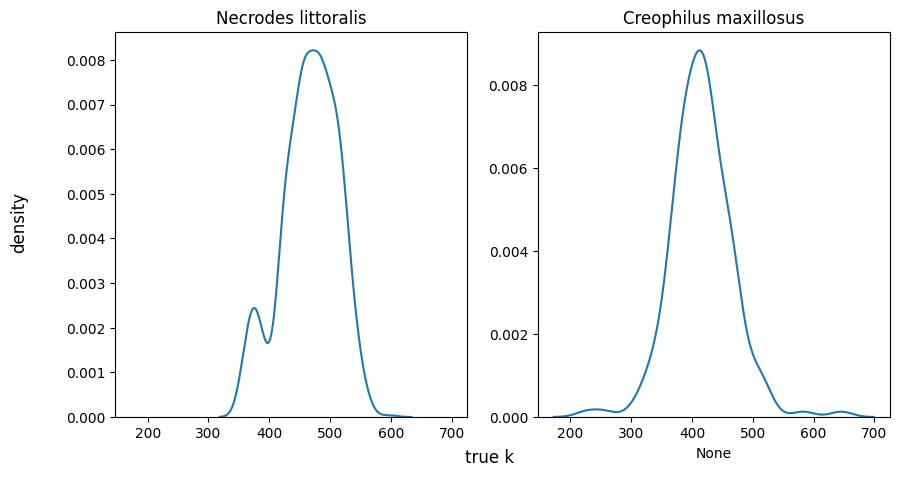

In [37]:
plot_density(necrodes_littoralis, 8.49, "Necrodes littoralis", 
             creophilus_maxillosus, 11.58, "Creophilus maxillosus")

## Python Implementation

#### Bayesian Information Criterion

In [38]:
# BIC

def BIC(density, n_coefs, debug_eps = 1e-10):
    return -2*np.sum(np.log(density + debug_eps)) + n_coefs*np.log(len(density))

# g density function

def g_density_function(data, t_0, weights, shape_k, lambda_scale, n_comp):
    g_den = weights[0] * \
            weibull_min.pdf(data['D']*(data['T'] - t_0[0]), \
                            c = shape_k[0], \
                            scale = lambda_scale[0])
    for i in range(1,n_comp):
        g_den = g_den + weights[i] * \
             weibull_min.pdf(data['D']*(data['T'] - t_0[i]), \
                             c = shape_k[i], \
                             scale = lambda_scale[i])
    return g_den

def g_density_function_2(data, weights, shape_k, lambda_scale, n_comp):
    g_den = weights[0] * \
            weibull_min.pdf(data, \
                            c = shape_k[0], \
                            scale = lambda_scale[0])
    for i in range(1,n_comp):
        g_den = g_den + weights[i] * \
             weibull_min.pdf(data, \
                             c = shape_k[i], \
                             scale = lambda_scale[i])
    return g_den

#### Algorithm EM

In [39]:
# optimization function

def f_weibull(D, T, scale_lambda, shape_k, t_0):
    ret = weibull_min.pdf(D*(T - t_0), c = shape_k, scale = scale_lambda)
    return ret + 1e-100

def log_f_weibull(D, T, scale_lambda, shape_k, t_0):
    ret = weibull_min.logpdf(D*(T - t_0), c = shape_k, scale = scale_lambda)
    return ret

def d_f_weibull_scale_lambda(D, T, scale_lambda, shape_k, t_0):
    ret = -((shape_k**2)*(np.exp(-((D*(T - t_0))/scale_lambda)**shape_k))*(((D*(T - t_0))/scale_lambda)**shape_k)*((((D*(T - t_0))/scale_lambda)**shape_k) - 1))/(D*(T - t_0)*scale_lambda)
    return ret + 1e-100

def d_f_weibull_shape_k(D, T, scale_lambda, shape_k, t_0):
    ret = (np.exp(-((D*(T - t_0))/scale_lambda)**shape_k))*(((D*(T - t_0))/scale_lambda)**shape_k)*(shape_k*((((D*(T - t_0))/scale_lambda)**shape_k)-1)*np.log(((D*(T - t_0))/scale_lambda) - 1))/(D*(t_0 - T))
    return ret + 1e-100

def d_f_weibull_t_0(D, T, scale_lambda, shape_k, t_0):
    ret = shape_k*(np.exp(-((D*(T - t_0))/scale_lambda)**shape_k))*(((D*(T - t_0))/scale_lambda)**shape_k)*(shape_k*(((D*(T - t_0))/scale_lambda)**shape_k) - shape_k + 1)/(D*(t_0 - T)**2)
    return ret + 1e-100

# actual algorithm

def EM_function(data, epsilon = 1e-06, n_comp = 2, debug_eps = 1e-10, lower_t_0 = 9, upper_t_0 = 12, emergency_stop = 500):
    
    n = len(data)
    dt = data
    pre_candidates_t_0 = random.choices(np.arange(lower_t_0, upper_t_0, 0.01), k=n_comp)
    pre_labels = random.choices(list(range(1,5)), k=n_comp)
    weights = pre_labels / np.sum(pre_labels)
    candidates_t_0 = random.choices(pre_candidates_t_0, weights=weights.tolist(), k=n)
    dt['candidates_t_0'] = candidates_t_0
    dt['k'] = dt['D']*(dt['T'] - dt['candidates_t_0'])

    scale_lambda = []
    shape_k = []
    t_0 = pre_candidates_t_0
    
    for position in pre_candidates_t_0:
        group_from_dt = dt[dt['candidates_t_0'] == position]['k']
        shape1, loc1, scale1 = weibull_min.fit(group_from_dt, floc=0)
        scale_lambda.append(scale1)
        shape_k.append(shape1)
        
        
    new_scale_lambda = scale_lambda
    new_shape_k = shape_k
    new_t_0 = t_0

    iter_step = 0
    convergence_criterion = False
    Q_function = float('-inf')
    Q_function_trace = []
    
    while not convergence_criterion:
        
        # E step
        
        v = np.random.rand(n,n_comp)
        for i in range(n_comp):
            v[:,i] = np.log(weights[i] + debug_eps) + log_f_weibull(dt['D'], dt['T'], scale_lambda[i], shape_k[i], t_0[i])
            
        for i in range(n):
            v[i,:] = np.exp(v[i,:] - np.max(v[i,:])) / np.sum(np.exp(v[i,:] - np.max(v[i,:])))
            v[i,:] = v[i,:] + debug_eps
            
        # M step
        
        ## weights
        
        weights_new = np.random.rand(n_comp)
        for i in range(n_comp - 1):
            weights_new[i] = (np.sum(v[:,i]) / np.sum(v[:,(n_comp - 1)] + v[:,i])) * (1 - np.sum(weights[:-1]) + weights[i])
        weights_new[-1] = 1 - np.sum(weights_new) + weights_new[-1]
        weights = weights_new
        
        ## t_0
        
        for i in range(n_comp):
            t_0_opt_function = lambda y: np.sum((v[:,i] / \
                                                f_weibull(D = dt['D'],
                                                          T = dt['T'],
                                                          scale_lambda = scale_lambda[i],
                                                          shape_k = shape_k[i],
                                                          t_0 = y)) * \
                                                d_f_weibull_t_0(D = dt['D'],
                                                                T = dt['T'],
                                                                scale_lambda = scale_lambda[i],
                                                                shape_k = shape_k[i],
                                                                t_0 = y))
            new_t_0[i] = root_scalar(t_0_opt_function, \
                                 bracket=[lower_t_0, upper_t_0],
                                 method='bisect').root
            
            #new_t_0[i] = root(t_0_opt_function, \
            #                  x0 = np.mean([lower_t_0, upper_t_0])).x
            
        ## scales
        
        for i in range(n_comp):
            scale_opt_function = lambda y: np.sum((v[:,i] / \
                                                   f_weibull(D = dt['D'],
                                                             T = dt['T'],
                                                             scale_lambda = scale_lambda[i],
                                                             shape_k = shape_k[i],
                                                             t_0 = y)) * \
                                                  d_f_weibull_scale_lambda(D = dt['D'],
                                                                           T = dt['T'],
                                                                           scale_lambda = scale_lambda[i],
                                                                           shape_k = shape_k[i],
                                                                           t_0 = y))
    
            new_scale_lambda[i] = root(scale_opt_function,
                                       x0 = scale_lambda[i]).x
        
        ## shapes
        
        for i in range(n_comp):
            shape_opt_function = lambda y: np.sum((v[:,i] / \
                                                   f_weibull(D = dt['D'],
                                                             T = dt['T'],
                                                             scale_lambda = scale_lambda[i],
                                                             shape_k = shape_k[i],
                                                             t_0 = y)) * \
                                                  d_f_weibull_shape_k(D = dt['D'],
                                                                      T = dt['T'],
                                                                      scale_lambda = scale_lambda[i],
                                                                      shape_k = shape_k[i],
                                                                      t_0 = y))
        
        
            new_shape_k[i] = root(shape_opt_function, \
                                  x0 = shape_k[i]).x
        
        
        
        ## check convergence
        
        shape_k = new_shape_k
        scale_lambda = new_scale_lambda
        t_0 = new_t_0
        
        Q_function_n = 0
         
        for i in range(0, n_comp):
            Q_function_n = Q_function_n +  np.sum(v[:,i]*(np.log(weights[i] + debug_eps) + log_f_weibull(D = dt['D'],
                                                                                                         T = dt['T'],
                                                                                                         scale_lambda = scale_lambda[i],
                                                                                                         shape_k = shape_k[i],
                                                                                                         t_0 = t_0[i]))) 
        
        
        if ((np.abs(Q_function - Q_function_n) < epsilon) or iter_step > emergency_stop):
            convergence_criterion = True
            
        Q_function = Q_function_n
        Q_function_trace.append(Q_function)
        iter_step = iter_step + 1
        
        for i in range(n_comp):
            if weights[i] <= 0:
                weights[i] = debug_eps
            if shape_k[i] <= 0:
                shape_k[i] = debug_eps
            if scale_lambda[i] <= 0:
                scale_lambda[i] = debug_eps
                
    if iter_step > emergency_stop:
        message = "Again!"
    else:
        message = "Algorithm succeeded."
        
    BICs = BIC(g_density_function(dt,
                                  t_0,
                                  weights,
                                  shape_k,
                                  scale_lambda,
                                  n_comp),
               n_coefs = n_comp * 3)
    
    return {'t_0': t_0,
            'weights': weights, 
            'shape': shape_k, 
            'scale': scale_lambda,
            'message': message,
            'BIC': BICs,
            'trace': Q_function_trace, 
            'steps': iter_step,
            'n_comp': n_comp}

#### Clustering

In [40]:
def cluster(data, t_0, weights, shape_k, lambda_scale, n_comp, debug_eps = 1e-10):
    
    labels = []
    
    for i in range(len(data)):
        pre_labels = [weights[0] * \
                      weibull_min.pdf((data['D']*(data['T'] - t_0[0]))[i], \
                                      c = shape_k[0] + debug_eps, \
                                      scale = lambda_scale[0] + debug_eps)]
        for j in range(1,n_comp):
            pre_labels.append(weights[j] * \
                              weibull_min.pdf((data['D']*(data['T'] - t_0[j]))[i], \
                                              c = shape_k[j] + debug_eps, \
                                              scale = lambda_scale[j] + debug_eps))
        
        pre_labels = pre_labels / sum(pre_labels)
        pre_labels = pre_labels.tolist()
        labels.append(t_0[pre_labels.index(max(pre_labels))])
        

    return labels

## Results

In [41]:
epsilon = 1e-6

### Creophilus maxillosus

#### Parameter $t_0$

start_time = time.time()
t0_estimate_creophilus_maxillosus = {"1": None,
                                     "2": None,
                                     "3": None,
                                     "4": None}


for k in tqdm([1,2,3,4]):
    iterations = 0
    check_message = "Again!"
    while (check_message == "Again!") and (iterations < 100):
        try:
            t0_estimate_creophilus_maxillosus[str(k)] = EM_function(creophilus_maxillosus, 
                                                                    epsilon = epsilon, 
                                                                    n_comp = k)
        except ValueError:
            print(f"Ponawiam próbę. ({k}: {iterations})")
            continue
        iterations += 1
        if t0_estimate_creophilus_maxillosus[str(k)] is not None:
                check_message = t0_estimate_creophilus_maxillosus[str(k)]['message']
duration = time.time() - start_time
print('Time duration:', round(duration/60, 2), 'minutes')

In [24]:
t0_estimate_creophilus_maxillosus

{'1': {'t_0': [11.458643669102912],
  'weights': array([1.]),
  'shape': [array([13.07784697])],
  'scale': [array([485.89014826])],
  'message': 'Algorithm succeeded.',
  'BIC': 2076.8267011491,
  'trace': [-1121.7510305288524, -1060.875308751481, -1060.875308751481],
  'steps': 3,
  'n_comp': 1},
 '2': {'t_0': [11.147248768369991, 11.250285037257072],
  'weights': array([0.12752056, 0.87247944]),
  'shape': [array([6.72334875]), array([14.03164187])],
  'scale': [array([556.65565319]), array([442.73558768])],
  'message': 'Algorithm succeeded.',
  'BIC': 1882.7701311599453,
  'trace': [-1064.7696674289177,
   -1011.8007753485125,
   -993.1574043705107,
   -981.2692303425956,
   -971.7102916710464,
   -965.3281247817745,
   -961.8963174413485,
   -960.3253303226504,
   -959.6998351195084,
   -959.4920430711536,
   -959.4485462447249,
   -959.4606198133927,
   -959.4858048392302,
   -959.5094969145644,
   -959.5279391050965,
   -959.5411653948615,
   -959.550251864322,
   -959.55634159

In [114]:
# Save pickle file
with open('t0_estimate_creophilus_maxillosus.pkl', 'wb') as f:
    pickle.dump(t0_estimate_creophilus_maxillosus, f)

In [42]:
# Load pickle file
with open('t0_estimate_creophilus_maxillosus.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

#loaded_data

In [43]:
t0_estimate_creophilus_maxillosus = loaded_data

In [44]:
t0_estimate_creophilus_maxillosus.keys()

dict_keys(['1', '2', '3', '4'])

In [45]:
bicsy = []
args = []
for key, value in t0_estimate_creophilus_maxillosus.items():
    args.append(int(key))
    bicsy.append(value['BIC'])

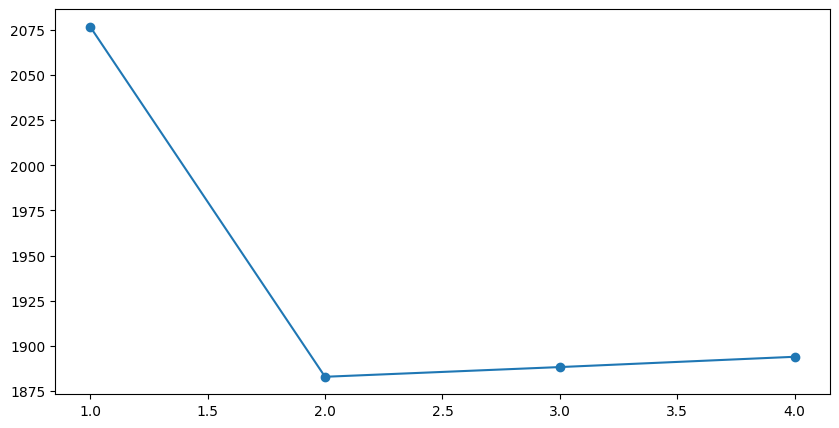

In [25]:
plt.plot(args, bicsy, marker='o')
plt.show()

<div style="text-align: center"> Figure 3. Posterior distribution of $t_0$ for Creophilus maxillosus. </div>

#### Parameter $k$

In [46]:
key = "2"

labels_creophilus_maxillosus = cluster(creophilus_maxillosus, \
                                       t0_estimate_creophilus_maxillosus[key]['t_0'], \
                                       t0_estimate_creophilus_maxillosus[key]['weights'], \
                                       t0_estimate_creophilus_maxillosus[key]['shape'], \
                                       t0_estimate_creophilus_maxillosus[key]['scale'], \
                                       t0_estimate_creophilus_maxillosus[key]['n_comp'])

t0_estimate_creophilus_maxillosus['density'] = g_density_function_2(np.linspace(100, 600, 1600),
                                                                  t0_estimate_creophilus_maxillosus[key]['weights'], 
                                                                  t0_estimate_creophilus_maxillosus[key]['shape'],
                                                                  t0_estimate_creophilus_maxillosus[key]['scale'],
                                                                  t0_estimate_creophilus_maxillosus[key]['n_comp'])
creophilus_maxillosus['t0'] = labels_creophilus_maxillosus
data_creophilus_maxillosus_k = creophilus_maxillosus['D']*(creophilus_maxillosus['T'] - creophilus_maxillosus['t0'])



In [47]:
print(t0_estimate_creophilus_maxillosus[key]['t_0'])
print(t0_estimate_creophilus_maxillosus[key]['weights'])
print(t0_estimate_creophilus_maxillosus[key]['shape'])
print(t0_estimate_creophilus_maxillosus[key]['scale'])

[11.147248768369991, 11.250285037257072]
[0.12752056 0.87247944]
[array([6.72334875]), array([14.03164187])]
[array([556.65565319]), array([442.73558768])]


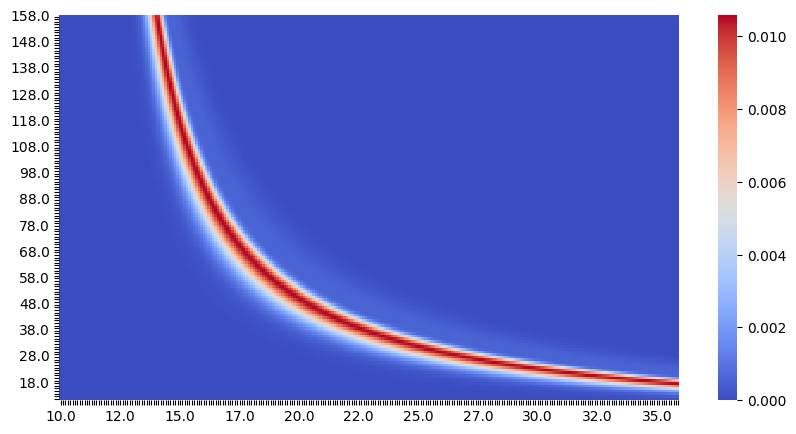

In [48]:
l1 = np.floor(np.min(creophilus_maxillosus['D'])) - 10
u1 = np.ceil(np.max(creophilus_maxillosus['D'])) + 10
days = np.arange(u1, l1 + 1, -1)
l2 = np.floor(np.min(creophilus_maxillosus['T'])) - 5 
u2 = np.ceil(np.max(creophilus_maxillosus['T'])) + 5
temps = np.arange(l2, u2 + 1, 0.1)

density = np.random.rand(len(days),len(temps))

for i in range(len(days)):
    for j in range(len(temps)):
        density[i,j] = g_density_function(pd.DataFrame({'D': days[i], 'T': temps[j]}, index=[0]),
                                          t0_estimate_creophilus_maxillosus[key]['t_0'], 
                                          t0_estimate_creophilus_maxillosus[key]['weights'], 
                                          t0_estimate_creophilus_maxillosus[key]['shape'], 
                                          t0_estimate_creophilus_maxillosus[key]['scale'], 
                                          t0_estimate_creophilus_maxillosus[key]['n_comp'])

sns.heatmap(density, 
            annot=False, 
            fmt=".2f", 
            cmap="coolwarm", 
            xticklabels=[label if i % 25 == 0 else '' for i, label in enumerate(np.round(temps))],
            yticklabels=[label if i % 10 == 0 else '' for i, label in enumerate(days)])
plt.show()        

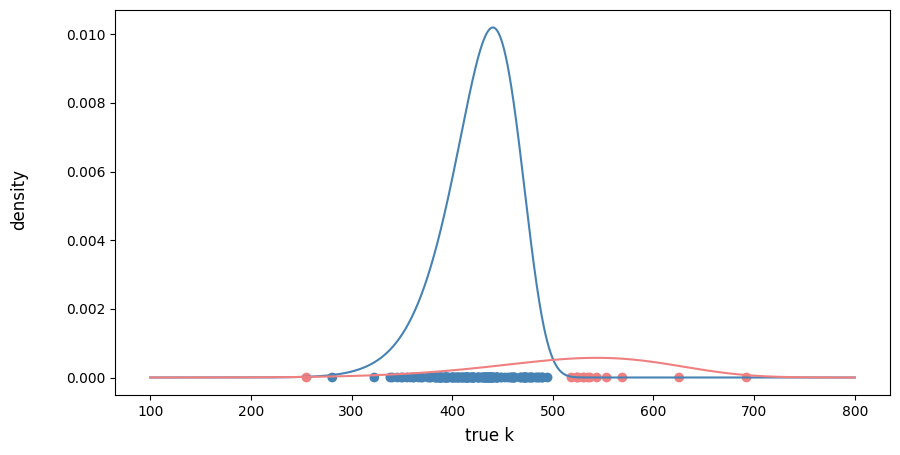

In [49]:
key = "2"
t0_list = [1,2,3,4]
for i in range(int(key)):
    t0_list[i] = t0_estimate_creophilus_maxillosus[key]['t_0'][i]
fig, ax = plt.subplots(1, 1, sharey=False, sharex = True,figsize=(10, 5))
#ax.set_title('density function')
fig.supylabel('density')
fig.supxlabel('true k')
ax.plot(np.linspace(100, 800, 1600), \
         t0_estimate_creophilus_maxillosus[key]['weights'][1] * weibull_min.pdf(np.linspace(100, 800, 1600), 
                             c = t0_estimate_creophilus_maxillosus[key]['shape'][1], 
                             scale = t0_estimate_creophilus_maxillosus[key]['scale'][1]),
       color = 'steelblue')
ax.plot(np.linspace(100, 800, 1600), \
        t0_estimate_creophilus_maxillosus[key]['weights'][0] * weibull_min.pdf(np.linspace(100, 800, 1600), 
                             c = t0_estimate_creophilus_maxillosus[key]['shape'][0], 
                             scale = t0_estimate_creophilus_maxillosus[key]['scale'][0]),
       color = 'lightcoral')
#ax.plot(np.linspace(100, 800, 1600), \
#        weibull_min.pdf(np.linspace(100, 800, 1600), 
#                             c = t0_estimate_creophilus_maxillosus[key]['shape'][2], 
#                             scale = t0_estimate_creophilus_maxillosus[key]['scale'][2]),
#       color = 'lightblue')
ax.scatter(data_creophilus_maxillosus_k, np.zeros(len(labels_creophilus_maxillosus)), \
              c = [{t0_list[3]: 'red', 
                    t0_list[2]: 'steelblue', 
                    t0_list[0]: 'lightcoral', 
                    t0_list[1]: 'steelblue'}[val] for val in labels_creophilus_maxillosus])
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('density_creophilus_maxillosus.png')
plt.show()

<div style="text-align: center"> Figure 5. Theoretical and empirical distributions of the parameter $k$ for Creophilus maxillosus. The shaded area represents the 95% confidence region for the density function. </div>

The theoretical probability distribution of Creophilus maxillosus's parameter $k$ closely resembles its empirical distribution. The heavy tails align with sparsely distributed observations that the algorithm classified as outliers/anomalies.

In [50]:
weights_creophilus_maxillosus

NameError: name 'weights_creophilus_maxillosus' is not defined

In [51]:
t0_estimate_creophilus_maxillosus["2"]['t_0']

[11.147248768369991, 11.250285037257072]

In [52]:
key = "2"
weights_creophilus_maxillosus = list(t0_estimate_creophilus_maxillosus[key]['weights'])
weights_index = weights_creophilus_maxillosus.index(max(weights_creophilus_maxillosus))
#weights_index = 3

creophilus_maxillosus_shape = t0_estimate_creophilus_maxillosus[key]['shape'][weights_index]
creophilus_maxillosus_scale = t0_estimate_creophilus_maxillosus[key]['scale'][weights_index]

prob_creophilus_maxillosus = 0.95
kwan = [0.025, 0.975]

int_creophilus_maxillosus = weibull_min.ppf(kwan, creophilus_maxillosus_shape, scale=creophilus_maxillosus_scale).tolist()
int_creophilus_maxillosus = np.round(int_creophilus_maxillosus).astype(int)

bool_mask = [(i == t0_list[weights_index]) for i in labels_creophilus_maxillosus]

creophilus_maxillosus_t0_data_2 = data_creophilus_maxillosus_k[bool_mask]


creophilus_maxillosus_mask = (creophilus_maxillosus_t0_data_2 <= int_creophilus_maxillosus[1]) & \
                                (creophilus_maxillosus_t0_data_2 >= int_creophilus_maxillosus[0])

cov_prob_creophilus_maxillosus = np.mean(creophilus_maxillosus_mask.astype(float))

print('k estimate:', int_creophilus_maxillosus)
print('probability:', prob_creophilus_maxillosus)
print('coverage probability:', np.round(cov_prob_creophilus_maxillosus, 2))

k estimate: [341 486]
probability: 0.95
coverage probability: 0.94


In [32]:
# Ikemoto & Takai's method

int_creophilus_maxillosus = [417.33 - 2*19.52, 417.33 + 2*19.52]
int_creophilus_maxillosus = np.round(int_creophilus_maxillosus).astype(int)

creophilus_maxillosus_mask = (creophilus_maxillosus_t0_data_2 <= int_creophilus_maxillosus[1]) & \
                                (creophilus_maxillosus_t0_data_2 >= int_creophilus_maxillosus[0])

cov_prob_creophilus_maxillosus = np.mean(creophilus_maxillosus_mask.astype(float))

print('k estimate:', int_creophilus_maxillosus)
print('probability:', prob_creophilus_maxillosus)
print('coverage probability:', np.round(cov_prob_creophilus_maxillosus, 2))

k estimate: [378 456]
probability: 0.95
coverage probability: 0.69


In [53]:
t0_estimate_creophilus_maxillosus[key]['t_0']

[11.147248768369991, 11.250285037257072]

In [57]:
weights_index

1

In [58]:
creophilus_maxillosus_shape2 = t0_estimate_creophilus_maxillosus[key]['shape'][0]
creophilus_maxillosus_scale2 = t0_estimate_creophilus_maxillosus[key]['scale'][0]

prob_creophilus_maxillosus = 0.95
kwan = [0.025, 0.975]
int_creophilus_maxillosus2 = weibull_min.ppf(kwan, creophilus_maxillosus_shape2, scale=creophilus_maxillosus_scale2).tolist()
int_creophilus_maxillosus2 = np.round(int_creophilus_maxillosus2).astype(int)

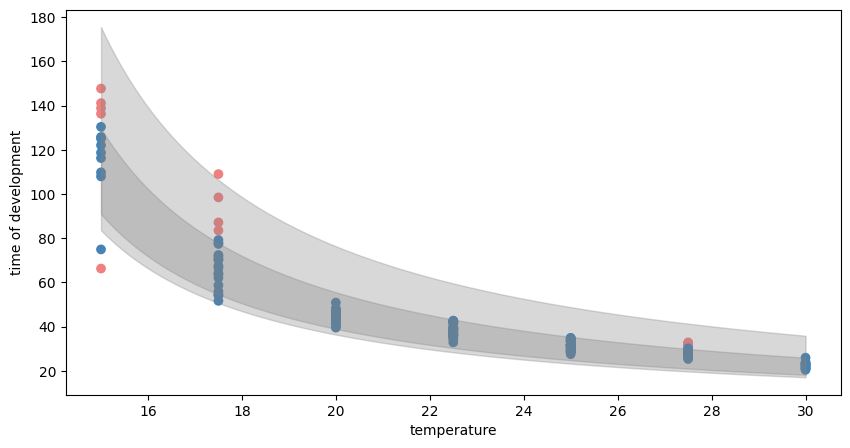

In [59]:
arguments_T = np.linspace(np.min(creophilus_maxillosus['T']), np.max(creophilus_maxillosus['T']), 1000)
plt.scatter(creophilus_maxillosus['T'], \
            creophilus_maxillosus['D'], \
            c = [{t0_list[3]: 'red', 
                  t0_list[2]: 'lightblue',
                  t0_list[0]: 'lightcoral',
                  t0_list[1]: 'steelblue'}[val] for val in labels_creophilus_maxillosus])
plt.fill_between(arguments_T, \
                 int_creophilus_maxillosus[0]/(arguments_T - t0_estimate_creophilus_maxillosus[key]['t_0'][weights_index]), \
                 int_creophilus_maxillosus[1]/(arguments_T - t0_estimate_creophilus_maxillosus[key]['t_0'][weights_index]), \
                 color='gray', \
                 alpha=0.3)
plt.fill_between(arguments_T, \
                 int_creophilus_maxillosus2[0]/(arguments_T - t0_estimate_creophilus_maxillosus[key]['t_0'][0]), \
                 int_creophilus_maxillosus2[1]/(arguments_T - t0_estimate_creophilus_maxillosus[key]['t_0'][0]), \
                 color='gray', \
                 alpha=0.3)
plt.ylabel('time of development')
plt.xlabel('temperature')
plt.savefig('cluster_creophilus_maxillosus.png')
plt.show()

In [78]:
maxillosus_extended = pd.read_excel("datasets/Creophilus_maxillosus.xlsx").iloc[:,[0,1,3,4]]
maxillosus_extended['t0'] = creophilus_maxillosus.t0
maxillosus_extended

,Total immature development,długość,Płeć,T,t0
0,109.791667,17.5,F,15.0,11.250285
1,141.125000,21.0,M,15.0,11.147249
2,147.708333,16.5,F,15.0,11.147249
3,74.916667,19.5,M,15.0,11.250285
4,66.250000,20.5,F,15.0,11.147249
...,...,...,...,...,...
168,23.416667,17.0,F,30.0,11.250285
169,23.208333,17.0,M,30.0,11.250285
170,23.958333,18.5,M,30.0,11.250285
171,21.043333,20.0,F,30.0,11.250285


In [79]:
print((378/(20-11.58)))
print((456/(20-11.58)))

44.89311163895487
54.156769596199524


In [82]:
# Ikemoto and Takai

practical_application = maxillosus_extended[maxillosus_extended['T'] == 20]
l1 = practical_application['Total immature development'] < 53
l2 = practical_application['Total immature development'] > 43

np.mean(l1 & l2)

0.75

In [88]:
print(np.min(practical_application['Total immature development']))
print((341/(20-11.25)))

39.5
38.97142857142857


In [89]:
print(np.max(practical_application['Total immature development']))
print((486/(20-11.25)))

50.8541666666667
55.542857142857144


In [84]:
# Ikemoto and Takai

practical_application = maxillosus_extended[maxillosus_extended['T'] == 20]
l1 = practical_application['Total immature development'] < (486/(20-11.25))
l2 = practical_application['Total immature development'] > (341/(20-11.25))

np.mean(l1 & l2)

1.0

In [96]:
kwants = [0.15, 0.85]

In [97]:
weibull_min.ppf(kwants, 
                creophilus_maxillosus_shape, 
                scale=creophilus_maxillosus_scale).tolist()

[388.9623202009561, 463.4080277310387]

In [61]:
t0_estimate_creophilus_maxillosus[key]['t_0']

[11.147248768369991, 11.250285037257072]

In [62]:
boolean_pars = list(set(maxillosus_extended.t0))

In [63]:
group0 = (maxillosus_extended[maxillosus_extended.t0 == boolean_pars[0]]).iloc[:,1]
group1 = (maxillosus_extended[maxillosus_extended.t0 == boolean_pars[1]]).iloc[:,1]
mannwhitneyu(group0, group1, alternative='two-sided')


MannwhitneyuResult(statistic=1047.0, pvalue=0.714536602843008)

In [64]:
cm = (maxillosus_extended)
np.std(cm.iloc[:,0]*(cm.iloc[:,3] - cm.iloc[:,4]))

53.71179228023209

In [65]:
cm1 = (maxillosus_extended[maxillosus_extended.t0 == boolean_pars[0]])
np.std(cm1.iloc[:,0]*(cm1.iloc[:,3] - cm1.iloc[:,4]))

90.01128393933153

In [66]:
cm2 = (maxillosus_extended[maxillosus_extended.t0 == boolean_pars[1]])
np.std(cm2.iloc[:,0]*(cm2.iloc[:,3] - cm2.iloc[:,4]))

37.92099957354429

In [67]:
38/54

0.7037037037037037

In [68]:
group0 = (maxillosus_extended[maxillosus_extended.t0 == boolean_pars[0]]).iloc[:,1]
group1 = (maxillosus_extended[maxillosus_extended.t0 == boolean_pars[1]]).iloc[:,1]

In [69]:
print(len(group0))
print(group0.mean())
print(len(group1))
print(group1.mean())

14
19.214285714285715
159
19.569182389937108


In [70]:
group0 = (maxillosus_extended[maxillosus_extended.t0 == t0_estimate_creophilus_maxillosus[key]['t_0'][0]]).iloc[:,2]
group1 = (maxillosus_extended[maxillosus_extended.t0 == t0_estimate_creophilus_maxillosus[key]['t_0'][1]]).iloc[:,2]
mannwhitneyu(group0.map({'F': 0, 'M': 1}), group1.map({'F': 0, 'M': 1}), alternative='two-sided')
#print(group1.map({'F': 0, 'M': 1}).mean())
#print(group0.map({'F': 0, 'M': 1}).mean())

MannwhitneyuResult(statistic=1217.0, pvalue=0.5057412440953384)

In [71]:
creophilus_maxillosus['labels'] = [{t0_list[3]: 0,
                                    t0_list[2]: 0,
                                    t0_list[1]: 1,
                                    t0_list[0]: 0}[val] for val in labels_creophilus_maxillosus]
creo_summary = creophilus_maxillosus.groupby('T').agg(opt = ('labels', 'mean'))
creo_summary['verdict'] = creo_summary['opt'] > 0.7
print(creo_summary)

           opt  verdict
T                      
15.0  0.642857    False
17.5  0.809524     True
20.0  1.000000     True
22.5  1.000000     True
25.0  1.000000     True
27.5  0.814815     True
30.0  1.000000     True


#### Bootstrap

In [187]:
# Ikemoto & Takai's method

int_creophilus_maxillosus = [417.33 - 2*19.52, 417.33 + 2*19.52]
int_creophilus_maxillosus = np.round(int_creophilus_maxillosus).astype(int)

bootstrap_sample = []
for i in range(1000):
    boot = creophilus_maxillosus[['D', 'T']].sample(n = len(creophilus_maxillosus[['D', 'T']]), replace = True)
    temp_df = boot.groupby('T')['D'].median().reset_index()
    bootstrap_sample.append(((temp_df['T'] - 11.58)*temp_df['D']).mean())

bootstrap_sample = pd.Series(bootstrap_sample)
creophilus_maxillosus_mask = (bootstrap_sample <= int_creophilus_maxillosus[1]) & \
                                (bootstrap_sample >= int_creophilus_maxillosus[0])

cov_prob_creophilus_maxillosus = np.mean(creophilus_maxillosus_mask.astype(float))

emp_int = list(bootstrap_sample.quantile([0.025, 0.975]))
emp_int = np.round(emp_int).astype(int)

print('IT k estimate:', int_creophilus_maxillosus)
print('Emp k estimate:', emp_int)
print('probability:', prob_creophilus_maxillosus)
print('coverage probability:', np.round(cov_prob_creophilus_maxillosus, 2))
print('bootstrap std:', bootstrap_sample.std())
print('stand_err:', 19.52)

IT k estimate: [378 456]
Emp k estimate: [405 423]
probability: 0.95
coverage probability: 1.0
bootstrap std: 4.958550727404734
stand_err: 19.52


In [192]:
# New method

mean_k = creophilus_maxillosus_t0_data_2.mean()
stand_err = creophilus_maxillosus_t0_data_2.std() / np.sqrt(len(creophilus_maxillosus_t0_data_2))

bool_mask = [(i == t0_list[weights_index]) for i in labels_creophilus_maxillosus]
creophilus_maxillosus_t0_data_2 = data_creophilus_maxillosus_k[bool_mask]

int_creophilus_maxillosus = [mean_k - 2*stand_err, mean_k + 2*stand_err]
#int_creophilus_maxillosus = np.round(int_creophilus_maxillosus).astype(int)

bootstrap_sample = []
for i in range(1000):
    boot = creophilus_maxillosus_t0_data_2.sample(n = len(creophilus_maxillosus_t0_data_2), replace = True)
    bootstrap_sample.append(boot.mean())

bootstrap_sample = pd.Series(bootstrap_sample)
creophilus_maxillosus_mask = (bootstrap_sample <= int_creophilus_maxillosus[1]) & \
                                (bootstrap_sample >= int_creophilus_maxillosus[0])

cov_prob_creophilus_maxillosus = np.mean(creophilus_maxillosus_mask.astype(float))

emp_int = list(bootstrap_sample.quantile([0.025, 0.975]))
#emp_int = np.round(emp_int).astype(int)

print('CLT k estimate:', int_creophilus_maxillosus)
print('Emp k estimate:', emp_int)
print('probability:', prob_creophilus_maxillosus)
print('coverage probability:', np.round(cov_prob_creophilus_maxillosus, 2))
print('bootstrap std:', bootstrap_sample.std())
print('stand_err:', stand_err)

CLT k estimate: [416.6414119477326, 428.7087429213157]
Emp k estimate: [416.97153334181854, 428.70959417094747]
probability: 0.95
coverage probability: 0.96
bootstrap std: 3.063309228010826
stand_err: 3.0168327433957915


### Necrodes littoralis

#### Parameter $t_0$

In [98]:
epsilon = 1e-7

start_time = time.time()
t0_estimate_necrodes_littoralis = {"1": None,
                                     "2": None,
                                     "3": None,
                                     "4": None}


for k in tqdm([1,2,3,4]):
    iterations = 0
    check_message = "Again!"
    while (check_message == "Again!") and (iterations < 100):
        try:
            t0_estimate_necrodes_littoralis[str(k)] = EM_function(necrodes_littoralis, 
                                                                    epsilon = epsilon, 
                                                                    n_comp = k)
        except ValueError:
            print(f"Ponawiam próbę. ({k}: {iterations})")
            continue
        iterations += 1
        if t0_estimate_necrodes_littoralis[str(k)] is not None:
                check_message = t0_estimate_necrodes_littoralis[str(k)]['message']
duration = time.time() - start_time
print('Time duration:', round(duration/60, 2), 'minutes')

In [79]:
t0_estimate_necrodes_littoralis

{'1': {'t_0': [11.013279511671044],
  'weights': array([1.]),
  'shape': [array([15.10324509])],
  'scale': [array([375.91222439])],
  'message': 'Algorithm succeeded.',
  'BIC': 11946.288485861924,
  'trace': [-6281.50171822337, -6047.193237562111, -6047.193237562111],
  'steps': 3,
  'n_comp': 1},
 '2': {'t_0': [11.225765895727363, 11.150156409914871],
  'weights': array([0.21358045, 0.78641955]),
  'shape': [array([15.30816572]), array([4.96613469])],
  'scale': [array([368.69689467]), array([343.01543372])],
  'message': 'Algorithm succeeded.',
  'BIC': 10562.5081517983,
  'trace': [-6909.89476423126,
   -5847.83718240537,
   -5831.895185646665,
   -5803.293619628275,
   -5772.240452676092,
   -5743.193017678509,
   -5718.83637205692,
   -5699.974887119397,
   -5686.053366575137,
   -5675.980529595222,
   -5668.693394570112,
   -5663.36325491107,
   -5659.402993595084,
   -5656.4119353882,
   -5654.11844078187,
   -5652.336562696826,
   -5650.936788267985,
   -5649.827087171436,
  

In [155]:
# Save pickle file
with open('t0_estimate_necrodes_littoralis.pkl', 'wb') as f:
    pickle.dump(t0_estimate_necrodes_littoralis, f)

In [99]:
# Load pickle file
with open('t0_estimate_necrodes_littoralis.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

#loaded_data

In [100]:
t0_estimate_necrodes_littoralis = loaded_data

In [101]:
bicsy = []
args = []
for key, value in t0_estimate_necrodes_littoralis.items():
    args.append(int(key))
    bicsy.append(value['BIC'])

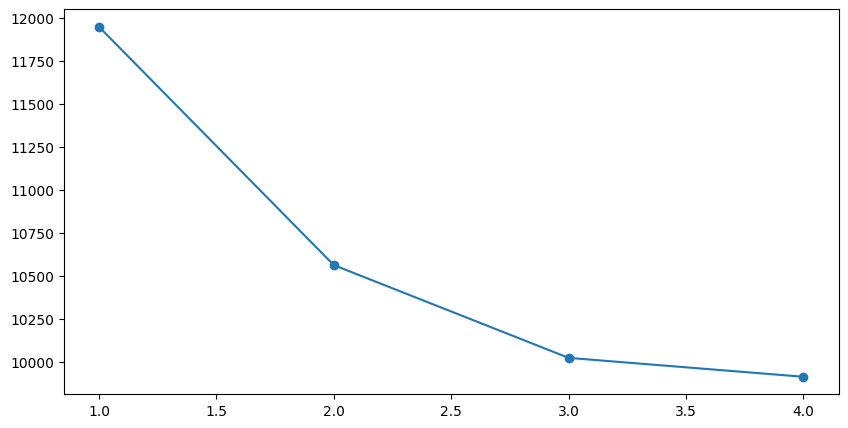

In [102]:
plt.plot(args, bicsy, marker='o')
plt.show()

<div style="text-align: center"> Figure 8. Posterior distribution of $t_0$ for Necrodes littoralis. </div>

#### Parameter $k$

In [103]:
key = "3"

labels_necrodes_littoralis = cluster(necrodes_littoralis, \
                                       t0_estimate_necrodes_littoralis[key]['t_0'], \
                                       t0_estimate_necrodes_littoralis[key]['weights'], \
                                       t0_estimate_necrodes_littoralis[key]['shape'], \
                                       t0_estimate_necrodes_littoralis[key]['scale'], \
                                       t0_estimate_necrodes_littoralis[key]['n_comp'])

t0_estimate_necrodes_littoralis['density'] = g_density_function_2(np.linspace(100, 600, 1600),
                                                                  t0_estimate_necrodes_littoralis[key]['weights'], 
                                                                  t0_estimate_necrodes_littoralis[key]['shape'],
                                                                  t0_estimate_necrodes_littoralis[key]['scale'],
                                                                  t0_estimate_necrodes_littoralis[key]['n_comp'])
necrodes_littoralis['t0'] = labels_necrodes_littoralis
data_necrodes_littoralis_k = necrodes_littoralis['D']*(necrodes_littoralis['T'] - necrodes_littoralis['t0'])



In [104]:
print(t0_estimate_necrodes_littoralis[key]['t_0'])
print(t0_estimate_necrodes_littoralis[key]['weights'])
print(t0_estimate_necrodes_littoralis[key]['shape'])
print(t0_estimate_necrodes_littoralis[key]['scale'])

[10.214476992123764, 11.44610922728998, 9.52003037591976]
[5.85914972e-01 2.74203928e-09 4.14085026e-01]
[array([13.66707391]), array([32.62339624]), array([14.56823929])]
[array([423.95495702]), array([352.25572523]), array([394.43998931])]


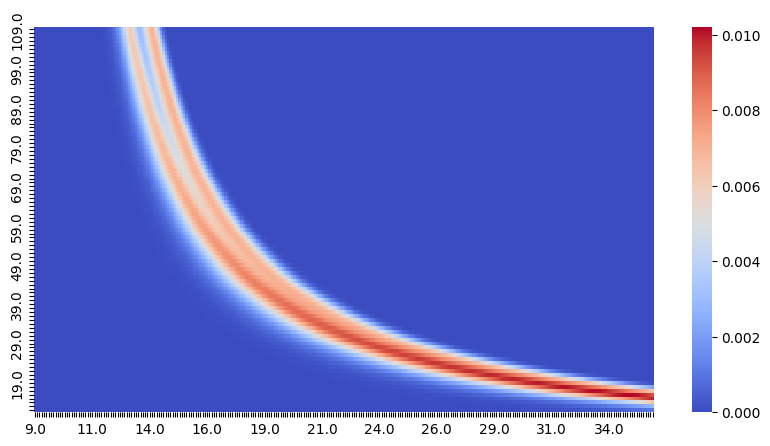

In [105]:
l1 = np.floor(np.min(necrodes_littoralis['D'])) - 10
u1 = np.ceil(np.max(necrodes_littoralis['D'])) + 10
days = np.arange(u1, l1 + 1, -1)
l2 = np.floor(np.min(necrodes_littoralis['T'])) - 5 
u2 = np.ceil(np.max(necrodes_littoralis['T'])) + 5
temps = np.arange(l2, u2 + 1, 0.1)

density = np.random.rand(len(days),len(temps))

for i in range(len(days)):
    for j in range(len(temps)):
        density[i,j] = g_density_function(pd.DataFrame({'D': days[i], 'T': temps[j]}, index=[0]),
                                          t0_estimate_necrodes_littoralis[key]['t_0'], 
                                          t0_estimate_necrodes_littoralis[key]['weights'], 
                                          t0_estimate_necrodes_littoralis[key]['shape'], 
                                          t0_estimate_necrodes_littoralis[key]['scale'], 
                                          t0_estimate_necrodes_littoralis[key]['n_comp'])

sns.heatmap(density, 
            annot=False, 
            fmt=".2f", 
            cmap="coolwarm", 
            xticklabels=[label if i % 25 == 0 else '' for i, label in enumerate(np.round(temps))],
            yticklabels=[label if i % 10 == 0 else '' for i, label in enumerate(days)])
plt.show()        

In [106]:
t0_estimate_necrodes_littoralis[key]['weights']

array([5.85914972e-01, 2.74203928e-09, 4.14085026e-01])

In [107]:
#for interection in np.arange(400, 420):
#    print(interection)
#    dist = weibull_min.pdf(interection, 
#                             c = t0_estimate_necrodes_littoralis[key]['shape'][0], 
#                             scale = t0_estimate_necrodes_littoralis[key]['scale'][0]) - weibull_min.pdf(interection, 
#                             c = t0_estimate_necrodes_littoralis[key]['shape'][2], 
#                             scale = t0_estimate_necrodes_littoralis[key]['scale'][2])
#    print(dist)
print(weibull_min.pdf(409, 
                             c = t0_estimate_necrodes_littoralis[key]['shape'][0], 
                             scale = t0_estimate_necrodes_littoralis[key]['scale'][0]))
print(weibull_min.pdf(409, 
                             c = t0_estimate_necrodes_littoralis[key]['shape'][2], 
                             scale = t0_estimate_necrodes_littoralis[key]['scale'][2]))

[0.01109049]
[0.01108171]


In [108]:
weibull_min.cdf(409, c=t0_estimate_necrodes_littoralis[key]['shape'][2], scale=t0_estimate_necrodes_littoralis[key]['scale'][2])

array([0.81652179])

In [109]:
weibull_min.cdf(409, c=t0_estimate_necrodes_littoralis[key]['shape'][0], scale=t0_estimate_necrodes_littoralis[key]['scale'][0])


array([0.45780451])

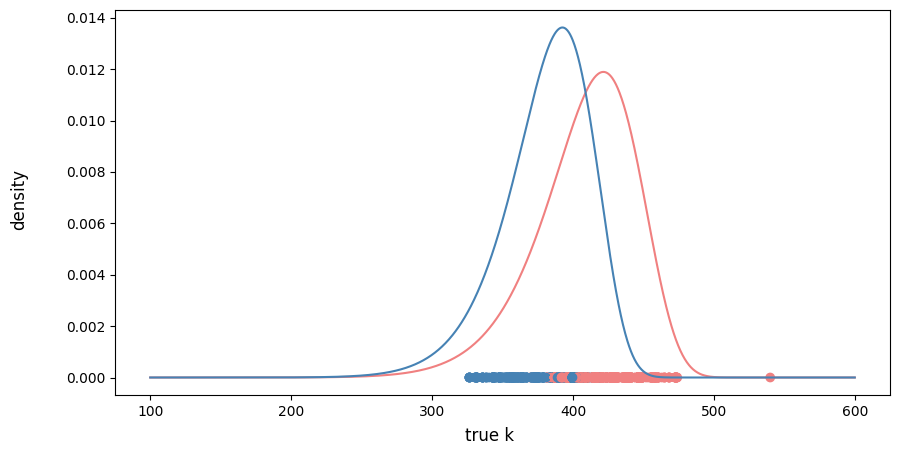

In [110]:
t0_list = [1,2,3,4]
for i in range(int(key)):
    t0_list[i] = t0_estimate_necrodes_littoralis[key]['t_0'][i]
fig, ax = plt.subplots(1, 1, sharey=False, sharex = True,figsize=(10, 5))
#ax.set_title('density function')
fig.supylabel('density')
fig.supxlabel('true k')
ax.plot(np.linspace(100, 600, 1600), \
         weibull_min.pdf(np.linspace(100, 600, 1600), 
                             c = t0_estimate_necrodes_littoralis[key]['shape'][0], 
                             scale = t0_estimate_necrodes_littoralis[key]['scale'][0]),
       color = 'lightcoral')
ax.plot(np.linspace(100, 600, 1600), \
        weibull_min.pdf(np.linspace(100, 600, 1600), 
                             c = t0_estimate_necrodes_littoralis[key]['shape'][2], 
                             scale = t0_estimate_necrodes_littoralis[key]['scale'][2]), 
                             #c = t0_estimate_necrodes_littoralis[key]['shape'][1], 
                             #scale = t0_estimate_necrodes_littoralis[key]['scale'][1]),
       color = 'steelblue')
ax.scatter(data_necrodes_littoralis_k, np.zeros(len(labels_necrodes_littoralis)), \
              c = [{t0_list[1]: 'lightblue', 
                    t0_list[2]: 'steelblue',
                    t0_list[3]: 'red',
                    t0_list[0]: 'lightcoral'}[val] for val in labels_necrodes_littoralis])
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('density_necrodes_littoralis.png')
plt.show()

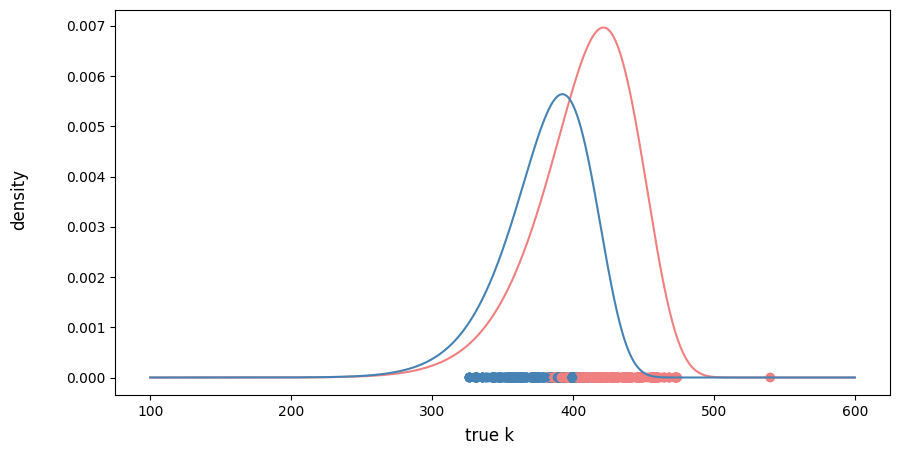

In [111]:
t0_list = [1,2,3,4]
for i in range(int(key)):
    t0_list[i] = t0_estimate_necrodes_littoralis[key]['t_0'][i]
fig, ax = plt.subplots(1, 1, sharey=False, sharex = True,figsize=(10, 5))
#ax.set_title('density function')
fig.supylabel('density')
fig.supxlabel('true k')
ax.plot(np.linspace(100, 600, 1600), \
         t0_estimate_necrodes_littoralis[key]['weights'][0] * weibull_min.pdf(np.linspace(100, 600, 1600), 
                             c = t0_estimate_necrodes_littoralis[key]['shape'][0], 
                             scale = t0_estimate_necrodes_littoralis[key]['scale'][0]),
       color = 'lightcoral')
ax.plot(np.linspace(100, 600, 1600), \
        t0_estimate_necrodes_littoralis[key]['weights'][2] * weibull_min.pdf(np.linspace(100, 600, 1600), 
                             c = t0_estimate_necrodes_littoralis[key]['shape'][2], 
                             scale = t0_estimate_necrodes_littoralis[key]['scale'][2]), 
                             #c = t0_estimate_necrodes_littoralis[key]['shape'][1], 
                             #scale = t0_estimate_necrodes_littoralis[key]['scale'][1]),
       color = 'steelblue')
ax.scatter(data_necrodes_littoralis_k, np.zeros(len(labels_necrodes_littoralis)), \
              c = [{t0_list[1]: 'lightblue', 
                    t0_list[2]: 'steelblue',
                    t0_list[3]: 'red',
                    t0_list[0]: 'lightcoral'}[val] for val in labels_necrodes_littoralis])
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('density_necrodes_littoralis.png')
plt.show()

In [112]:
list(t0_estimate_necrodes_littoralis[key]['weights'])

[0.5859149715679594, 2.7420392751270326e-09, 0.4140850256900014]

In [113]:
weights_necrodes_littoralis = list(t0_estimate_necrodes_littoralis[key]['weights'])
weights_index = weights_necrodes_littoralis.index(max(weights_necrodes_littoralis))
weights_index = 2

necrodes_littoralis_shape = t0_estimate_necrodes_littoralis[key]['shape'][weights_index]
necrodes_littoralis_scale = t0_estimate_necrodes_littoralis[key]['scale'][weights_index]

prob_necrodes_littoralis = 0.90 - 0.025
kwan = [0.037, 0.90]

int_necrodes_littoralis = weibull_min.ppf(kwan, necrodes_littoralis_shape, scale=necrodes_littoralis_scale).tolist()
int_necrodes_littoralis = np.round(int_necrodes_littoralis).astype(int)

bool_mask = [(i == t0_list[weights_index]) for i in labels_necrodes_littoralis]

necrodes_littoralis_t0_data_2 = data_necrodes_littoralis_k[bool_mask]


necrodes_littoralis_mask = (necrodes_littoralis_t0_data_2 <= int_necrodes_littoralis[1]) & \
                                (necrodes_littoralis_t0_data_2 >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))

print('k estimate:', int_necrodes_littoralis)
print('probability:', prob_necrodes_littoralis)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))

k estimate: [315 418]
probability: 0.875
coverage probability: 0.99


In [114]:
t0_estimate_necrodes_littoralis[key]['scale']

[array([423.95495702]), array([352.25572523]), array([394.43998931])]

In [115]:
# wszystkie

int_necrodes_littoralis = [315, 460]
data_necrodes_littoralis_k


necrodes_littoralis_mask = (data_necrodes_littoralis_k <= int_necrodes_littoralis[1]) & \
                                (data_necrodes_littoralis_k >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))

print('k estimate:', int_necrodes_littoralis)
print('probability:', 0.95)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))

k estimate: [315, 460]
probability: 0.95
coverage probability: 0.97


In [116]:
[315 418]
[360 460]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2533442655.py, line 1)

In [211]:
weights_necrodes_littoralis = list(t0_estimate_necrodes_littoralis[key]['weights'])
weights_index = weights_necrodes_littoralis.index(max(weights_necrodes_littoralis))
weights_index = 0

necrodes_littoralis_shape = t0_estimate_necrodes_littoralis[key]['shape'][weights_index]
necrodes_littoralis_scale = t0_estimate_necrodes_littoralis[key]['scale'][weights_index]

#prob_necrodes_littoralis = 0.951 - 0.1
#kwan = [0.1, 0.951]

#kwan = [0.025, 0.975]
kwan = [0.15, 0.85]
prob_necrodes_littoralis = kwan[1] - kwan[0]

int_necrodes_littoralis = weibull_min.ppf(kwan, necrodes_littoralis_shape, scale=necrodes_littoralis_scale).tolist()
int_necrodes_littoralis = np.round(int_necrodes_littoralis).astype(int)

bool_mask = [(i == t0_list[weights_index]) for i in labels_necrodes_littoralis]

necrodes_littoralis_t0_data_2 = data_necrodes_littoralis_k[bool_mask]


necrodes_littoralis_mask = (necrodes_littoralis_t0_data_2 <= int_necrodes_littoralis[1]) & \
                                (necrodes_littoralis_t0_data_2 >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))

print('czerwone')
print('k estimate:', int_necrodes_littoralis)
print('probability:', prob_necrodes_littoralis)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))
print(t0_estimate_necrodes_littoralis[key]['weights'][weights_index])

czerwone
k estimate: [371 444]
probability: 0.7
coverage probability: 0.76
0.5859149715679594


In [208]:
weights_necrodes_littoralis = list(t0_estimate_necrodes_littoralis[key]['weights'])
weights_index = weights_necrodes_littoralis.index(max(weights_necrodes_littoralis))
weights_index = 2

necrodes_littoralis_shape = t0_estimate_necrodes_littoralis[key]['shape'][weights_index]
necrodes_littoralis_scale = t0_estimate_necrodes_littoralis[key]['scale'][weights_index]

#prob_necrodes_littoralis = 0.88 - 0.037
#kwan = [0.037, 0.88]

kwan = [0.025, 0.975]
#kwan = [0.15, 0.85]
prob_necrodes_littoralis = kwan[1] - kwan[0]


int_necrodes_littoralis = weibull_min.ppf(kwan, necrodes_littoralis_shape, scale=necrodes_littoralis_scale).tolist()
int_necrodes_littoralis = np.round(int_necrodes_littoralis).astype(int)

bool_mask = [(i == t0_list[weights_index]) for i in labels_necrodes_littoralis]

necrodes_littoralis_t0_data_2 = data_necrodes_littoralis_k[bool_mask]


necrodes_littoralis_mask = (necrodes_littoralis_t0_data_2 <= int_necrodes_littoralis[1]) & \
                                (necrodes_littoralis_t0_data_2 >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))

print('niebieskie')
print('k estimate:', int_necrodes_littoralis)
print('probability:', prob_necrodes_littoralis)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))
print(t0_estimate_necrodes_littoralis[key]['weights'][weights_index])

niebieskie
k estimate: [306 431]
probability: 0.95
coverage probability: 1.0
0.4140850256900014


In [204]:
weights_necrodes_littoralis = list(t0_estimate_necrodes_littoralis[key]['weights'])
weights_index = weights_necrodes_littoralis.index(max(weights_necrodes_littoralis))
weights_index = 2

necrodes_littoralis_shape = t0_estimate_necrodes_littoralis[key]['shape'][weights_index]
necrodes_littoralis_scale = t0_estimate_necrodes_littoralis[key]['scale'][weights_index]

#prob_necrodes_littoralis = 0.88 - 0.037
#kwan = [0.037, 0.88]

kwan = [0.025, 0.975]
prob_necrodes_littoralis = kwan[1] - kwan[0]


int_necrodes_littoralis = [306, 466]
int_necrodes_littoralis = np.round(int_necrodes_littoralis).astype(int)

necrodes_littoralis_t0_data_2 = data_necrodes_littoralis_k


necrodes_littoralis_mask = (necrodes_littoralis_t0_data_2 <= int_necrodes_littoralis[1]) & \
                                (necrodes_littoralis_t0_data_2 >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))

print('wszystkie')
print('k estimate:', int_necrodes_littoralis)
print('probability:', prob_necrodes_littoralis)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))
print(t0_estimate_necrodes_littoralis[key]['weights'][weights_index])

wszystkie
k estimate: [306 466]
probability: 0.95
coverage probability: 0.98
0.4140850256900014


In [119]:
# Ikemoto & Takai's method

int_necrodes_littoralis = [468.89 - 2*24.59, 468.89 + 2*24.59]
int_necrodes_littoralis = np.round(int_necrodes_littoralis).astype(int)

necrodes_littoralis_mask = (necrodes_littoralis_t0_data_2 <= int_necrodes_littoralis[1]) & \
                                (necrodes_littoralis_t0_data_2 >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))

print('k estimate:', int_necrodes_littoralis)
print('probability:', prob_necrodes_littoralis)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))

k estimate: [420 518]
probability: 0.875
coverage probability: 0.0


In [131]:
t0_estimate_necrodes_littoralis[key]['weights']

array([5.85914972e-01, 2.74203928e-09, 4.14085026e-01])

In [121]:
weights_index

2

In [201]:
necrodes_littoralis_shape2 = t0_estimate_necrodes_littoralis[key]['shape'][0]
necrodes_littoralis_scale2 = t0_estimate_necrodes_littoralis[key]['scale'][0]

#prob_necrodes_littoralis2 = 0.975 - 0.25
#kwan = [0.10, 0.951]

kwan = [0.025, 0.975]
prob_necrodes_littoralis = kwan[1] - kwan[0]

int_necrodes_littoralis2 = weibull_min.ppf(kwan, necrodes_littoralis_shape2, scale=necrodes_littoralis_scale2).tolist()
int_necrodes_littoralis2 = np.round(int_necrodes_littoralis2).astype(int)

In [202]:
print(int_necrodes_littoralis)
print(int_necrodes_littoralis2)

[306 431]
[324 466]


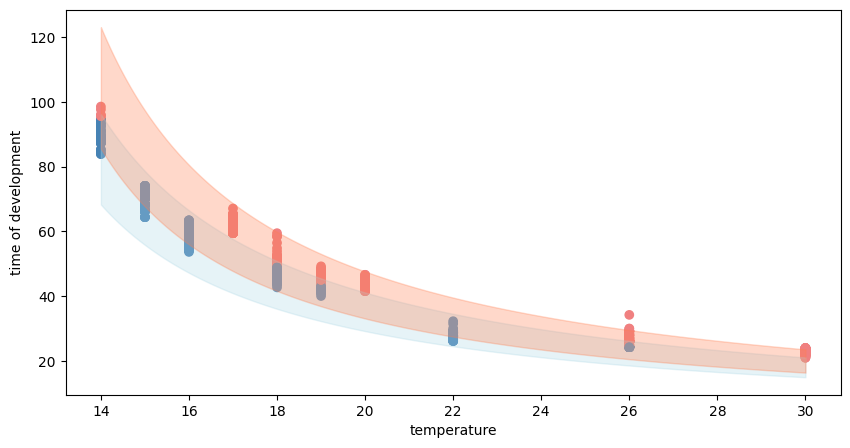

In [203]:
arguments_T = np.linspace(np.min(necrodes_littoralis['T']), np.max(necrodes_littoralis['T']), 1000)
plt.scatter(necrodes_littoralis['T'], \
            necrodes_littoralis['D'], \
            c = [{t0_list[1]: 'lightblue', 
                  t0_list[2]: 'steelblue',
                  t0_list[3]: 'red',
                  t0_list[0]: 'lightcoral'}[val] for val in labels_necrodes_littoralis])
plt.fill_between(arguments_T, \
                 int_necrodes_littoralis[0]/(arguments_T - t0_estimate_necrodes_littoralis[key]['t_0'][weights_index]), \
                 int_necrodes_littoralis[1]/(arguments_T - t0_estimate_necrodes_littoralis[key]['t_0'][weights_index]), \
                 color='lightblue', \
                 alpha=0.3)
plt.fill_between(arguments_T, \
                 int_necrodes_littoralis2[0]/(arguments_T - t0_estimate_necrodes_littoralis[key]['t_0'][0]), \
                 int_necrodes_littoralis2[1]/(arguments_T - t0_estimate_necrodes_littoralis[key]['t_0'][0]), \
                 color='coral', \
                 alpha=0.3)
plt.ylabel('time of development')
plt.xlabel('temperature')
plt.savefig('cluster_necrodes_littoralis.png')
plt.show()

In [135]:
necrodes_littoralis['labels'] = [{t0_list[3]: 0,
                                    t0_list[2]: 1,
                                    t0_list[1]: 0,
                                    t0_list[0]: 0}[val] for val in labels_necrodes_littoralis]
necro_summary = necrodes_littoralis.groupby('T').agg(opt = ('labels', 'mean'))
necro_summary['verdict'] = necro_summary['opt'] > 0.7
print(necro_summary)

         opt  verdict
T                    
14  0.907407     True
15  1.000000     True
16  1.000000     True
17  0.000000    False
18  0.620000    False
19  0.230000    False
20  0.000000    False
22  1.000000     True
26  0.310000    False
30  0.000000    False


In [126]:
# Ikemoto & Takai's method

int_necrodes_littoralis = [468.89 - 2*24.59, 468.89 + 2*24.59]
int_necrodes_littoralis = np.round(int_necrodes_littoralis).astype(int)

bootstrap_sample = []
for i in range(1000):
    boot = necrodes_littoralis[['D', 'T']].sample(n = len(necrodes_littoralis[['D', 'T']]), replace = True)
    temp_df = boot.groupby('T')['D'].median().reset_index()
    bootstrap_sample.append(((temp_df['T'] - 8.49)*temp_df['D']).mean())

bootstrap_sample = pd.Series(bootstrap_sample)
necrodes_littoralis_mask = (bootstrap_sample <= int_necrodes_littoralis[1]) & \
                                (bootstrap_sample >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))

emp_int = list(bootstrap_sample.quantile([0.025, 0.975]))
emp_int = np.round(emp_int).astype(int)

print('IT k estimate:', int_necrodes_littoralis)
print('Emp k estimate:', emp_int)
print('probability:', prob_necrodes_littoralis)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))
print('bootstrap std:', bootstrap_sample.std())
print('stand_err:', 24.59)

IT k estimate: [420 518]
Emp k estimate: [464 468]
probability: 0.875
coverage probability: 1.0
bootstrap std: 0.8920862857113986
stand_err: 24.59


In [127]:
# New method

bool_mask = [(i == t0_list[weights_index]) for i in labels_necrodes_littoralis]
necrodes_littoralis_t0_data_2 = data_necrodes_littoralis_k[bool_mask]

mean_k = necrodes_littoralis_t0_data_2.mean()
stand_err = necrodes_littoralis_t0_data_2.std() / np.sqrt(len(necrodes_littoralis_t0_data_2))

int_necrodes_littoralis = [mean_k - 2*stand_err, mean_k + 2*stand_err]
#int_creophilus_maxillosus = np.round(int_creophilus_maxillosus).astype(int)

bootstrap_sample = []
for i in range(1000):
    boot = necrodes_littoralis_t0_data_2.sample(n = len(necrodes_littoralis_t0_data_2), replace = True)
    bootstrap_sample.append(boot.mean())

bootstrap_sample = pd.Series(bootstrap_sample)
necrodes_littoralis_mask = (bootstrap_sample <= int_necrodes_littoralis[1]) & \
                                (bootstrap_sample >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))
emp_int = list(bootstrap_sample.quantile([0.025, 0.975]))
#emp_int = np.round(emp_int).astype(int)

print('CLT k estimate:', int_necrodes_littoralis)
print('Emp k estimate:', emp_int)
print('probability:', prob_necrodes_littoralis)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))
print('bootstrap std:', bootstrap_sample.std())
print('stand_err:', stand_err)

CLT k estimate: [376.7858531332483, 381.03065446177874]
Emp k estimate: [376.7765757125917, 380.8442066003145]
probability: 0.875
coverage probability: 0.96
bootstrap std: 1.0318665162990146
stand_err: 1.0612003321326229


In [79]:
# New method

bool_mask = [(i == t0_list[0]) for i in labels_necrodes_littoralis]
necrodes_littoralis_t0_data_2 = data_necrodes_littoralis_k[bool_mask]

mean_k = necrodes_littoralis_t0_data_2.mean()
stand_err = necrodes_littoralis_t0_data_2.std() / np.sqrt(len(necrodes_littoralis_t0_data_2))

int_necrodes_littoralis = [mean_k - 2*stand_err, mean_k + 2*stand_err]
#int_creophilus_maxillosus = np.round(int_creophilus_maxillosus).astype(int)

bootstrap_sample = []
for i in range(1000):
    boot = necrodes_littoralis_t0_data_2.sample(n = len(necrodes_littoralis_t0_data_2), replace = True)
    bootstrap_sample.append(boot.mean())

bootstrap_sample = pd.Series(bootstrap_sample)
necrodes_littoralis_mask = (bootstrap_sample <= int_necrodes_littoralis[1]) & \
                                (bootstrap_sample >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))
emp_int = list(bootstrap_sample.quantile([0.025, 0.975]))
#emp_int = np.round(emp_int).astype(int)

print('CLT k estimate:', int_necrodes_littoralis)
print('Emp k estimate:', emp_int)
print('probability:', prob_necrodes_littoralis)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))
print('bootstrap std:', bootstrap_sample.std())
print('stand_err:', stand_err)

CLT k estimate: [422.71333034407866, 426.9508603903924]
Emp k estimate: [422.77424179804035, 426.75823240038414]
probability: 0.875
coverage probability: 0.96
bootstrap std: 1.036415836429465
stand_err: 1.059382511578446


In [80]:
# New method

bool_mask = [(i == t0_list[0]) for i in labels_necrodes_littoralis]
necrodes_littoralis_t0_data_2 = data_necrodes_littoralis_k

mean_k = necrodes_littoralis_t0_data_2.mean()
stand_err = necrodes_littoralis_t0_data_2.std() / np.sqrt(len(necrodes_littoralis_t0_data_2))

int_necrodes_littoralis = [mean_k - 2*stand_err, mean_k + 2*stand_err]
#int_creophilus_maxillosus = np.round(int_creophilus_maxillosus).astype(int)

bootstrap_sample = []
for i in range(1000):
    boot = necrodes_littoralis_t0_data_2.sample(n = len(necrodes_littoralis_t0_data_2), replace = True)
    bootstrap_sample.append(boot.mean())

bootstrap_sample = pd.Series(bootstrap_sample)
necrodes_littoralis_mask = (bootstrap_sample <= int_necrodes_littoralis[1]) & \
                                (bootstrap_sample >= int_necrodes_littoralis[0])

cov_prob_necrodes_littoralis = np.mean(necrodes_littoralis_mask.astype(float))
emp_int = list(bootstrap_sample.quantile([0.025, 0.975]))
#emp_int = np.round(emp_int).astype(int)

print('CLT k estimate:', int_necrodes_littoralis)
print('Emp k estimate:', emp_int)
print('probability:', prob_necrodes_littoralis)
print('coverage probability:', np.round(cov_prob_necrodes_littoralis, 2))
print('bootstrap std:', bootstrap_sample.std())
print('stand_err:', stand_err)

CLT k estimate: [400.3362177524545, 404.5594481813442]
Emp k estimate: [400.56217442567413, 404.69512373622035]
probability: 0.875
coverage probability: 0.95
bootstrap std: 1.0919573192136078
stand_err: 1.0558076072224196


In [136]:
LENGTH = pd.read_excel("datasets/Necrodes_littoralis.xlsx").LENGTH

In [137]:
pd.read_excel("datasets/Necrodes_littoralis.xlsx")['TIME (D)']

0      89.583333
1      87.583333
2      88.583333
3      88.583333
4      98.583333
         ...    
949    23.166667
950    23.666667
951    23.666667
952    23.666667
953    23.666667
Name: TIME (D), Length: 954, dtype: float64

In [138]:
t0_estimate_necrodes_littoralis[key]['t_0'][2]

9.52003037591976

In [139]:
list(set(labels_necrodes_littoralis))

[9.52003037591976, 10.214476992123764]

In [140]:
g_df = \
pd.DataFrame({'label':labels_necrodes_littoralis,
              'temp': necrodes_littoralis['T'],
              'LENGTH': LENGTH,
              'D': pd.read_excel("datasets/Necrodes_littoralis.xlsx")['TIME (D)']})


print(g_df[['label', 'LENGTH']].groupby('label').agg(W = ('LENGTH', 'mean'), counts=('LENGTH', 'count')))

                   W  counts
label                       
9.520030   17.749462     465
10.214477  16.958078     489


In [152]:
print(420/(22-8.49))
print(518/(22-8.49))

31.088082901554404
38.3419689119171


In [194]:
# Ikemoto and Takai
ttt = 22
practical_application = g_df[(g_df['LENGTH'] >= 18) & (g_df['temp'] == ttt)]
l1 = practical_application['D'] < 518/(ttt-8.49)
l2 = practical_application['D'] > 420/(ttt-8.49)
np.mean(l1 & l2)

0.021052631578947368

In [212]:
print(306/(22-9.52))
print(431/(22-9.52))

24.51923076923077
34.53525641025641


In [213]:
ttt = 22
practical_application = g_df[(g_df['LENGTH'] >= 18) & (g_df['temp'] == ttt)]
l1 = practical_application['D'] < 431/(ttt-9.52)
l2 = practical_application['D'] > 306/(ttt-9.52)
np.mean(l1 & l2)

1.0

In [ ]:
kwants = [0.025,0.975]
weibull_min.ppf(kwants, 
                creophilus_maxillosus_shape, 
                scale=creophilus_maxillosus_scale).tolist()

In [162]:
set(practical_application.temp)

{16, 18, 19, 20, 22, 26, 30}

In [141]:
print(np.round(t0_estimate_necrodes_littoralis[key]['t_0'],2))
print(np.round(t0_estimate_necrodes_littoralis[key]['weights'],2))

[10.21 11.45  9.52]
[0.59 0.   0.41]


In [142]:
group0 = g_df[g_df.label == t0_estimate_necrodes_littoralis[key]['t_0'][2]].LENGTH
group1 = g_df[g_df.label == t0_estimate_necrodes_littoralis[key]['t_0'][0]].LENGTH

In [143]:
nl1 = g_df[g_df.label == t0_estimate_necrodes_littoralis[key]['t_0'][2]]
np.std(nl1.iloc[:,3]*(nl1.iloc[:,1] - nl1.iloc[:,0]))

22.85895472768019

In [144]:
nl2 = g_df[g_df.label == t0_estimate_necrodes_littoralis[key]['t_0'][0]]
np.std(nl2.iloc[:,3]*(nl2.iloc[:,1] - nl2.iloc[:,0]))

23.402524591356997

In [145]:
nl = g_df
np.std(nl.iloc[:,3]*(nl.iloc[:,1] - nl.iloc[:,0]))

32.593517874045155

In [146]:
23/33

0.696969696969697

In [147]:
nl1 = g_df[g_df.label == t0_estimate_necrodes_littoralis[key]['t_0'][2]]

In [144]:
stats.shapiro(group0)

ShapiroResult(statistic=0.9832379010548951, pvalue=3.336390362723989e-05)

In [145]:
stats.shapiro(group1)

ShapiroResult(statistic=0.9755773645393346, pvalue=2.7302614283715023e-07)

In [146]:
levene(group0, group1)

LeveneResult(statistic=2.933763046898873, pvalue=0.08707069261732678)

In [147]:
ttest_ind(group0, group1, equal_var=True)

TtestResult(statistic=6.976295868114468, pvalue=5.669365961348028e-12, df=952.0)

In [148]:
mannwhitneyu(group0, group1, alternative='two-sided')

MannwhitneyuResult(statistic=141280.5, pvalue=6.162802198418677e-11)